<a href="https://colab.research.google.com/github/sfrankland/ConjugateSymmetry/blob/main/Weeks1%262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Weeks 1 and 2: Feedforward Neural Networks

The basic structure of a feedforward neural network often looks like this....

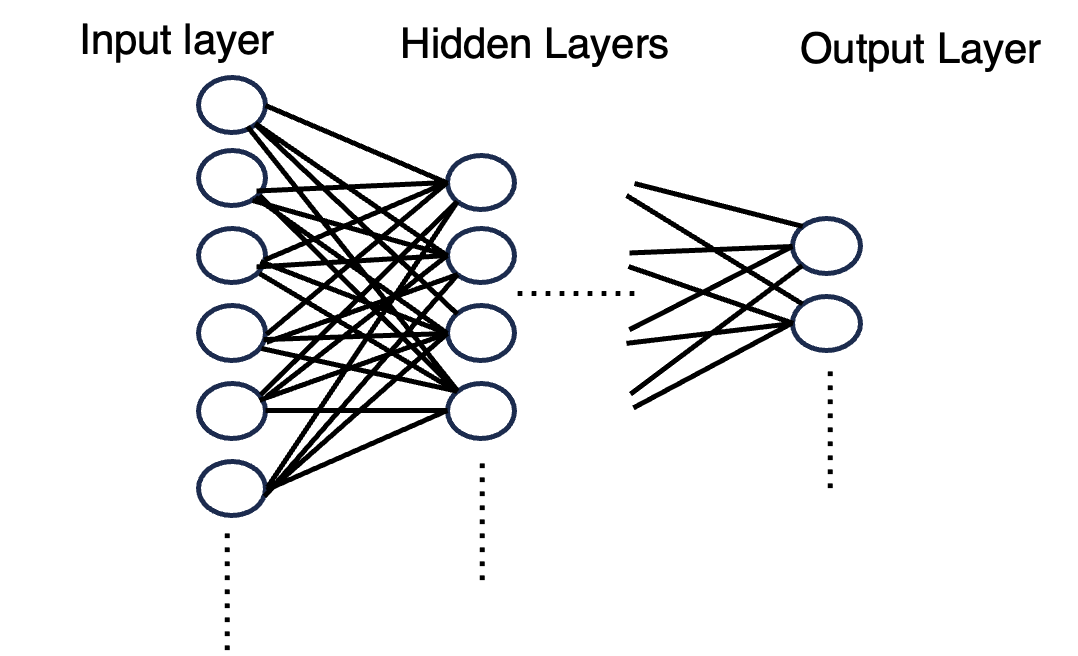


It has a few basic types of parts:

- <b> <i> nodes </i> </b>  (the circles). represent the <i>value of some variable </i>.

    - In the <b> first </b> "layer", the nodes represent the <b> input </b> variables. for example, the pixels in an image, the words in a sentence etc --- i.e., whatever data we present to the network. if we are modeling an agent, this might be <b> sensory </b> data. If we are modeling a <i> particular cognitive process </i>, it is the input to that process.  
    - In the <b>last</b> layer of the network, they represent <b> output </b> variables -- categories, decision-variables etc --- whatever variables we want to evaluate the network's ability on.
    - The <b>intermediate </b> variables are the most interesting: they actually represent <b>representations</b> themselves -- i.e., intermediate, internal states that mediate between the input and output. These are the network's "thoughts". They influence how the network interprets and processes the data it receives.

        - A <b><i> layer </b></i> is a population of nodes at the same stage of information processing --- they receive inputs from a preceding population (layer) and pass outputs to a subsequent population (layer).


The values of nodes at each stage are determined by:

- <b>weights </b> (the lines connecting nodes). This is where knowledge is stored in a feedforward network.
  
  - Each "upstream" node is multiplied by these weights, as it is passed on to the next layer.
  
  - The value of each "downstream" node is a weighted combination of the activities from all the nodes it receives. We need some way of determining what weights are best suited to an information-processing task. This is the <i>learning</i> problem.


- <b>activation </b> functions. These are non-linear transformations on each node's value.


Two different stages neural networks exploration:
- <b> how they learn </b> (changing the weights/activity states to optimize the <i> loss </i> function)
    - <b> objective ("loss") function </b>: (what does the system seek to achieve?)


- <b> how they process information ("inference") </b> (normally after learning, changing the weights/activity states to perform some task

  - in inference, information flows "forward" for processing.
  - in learning, information flows "backward" for learning.


<b> Representational Space </b>. A common idea that we will frequently return to is a "representational space". Imagine that the nodes in a layer of a network are the <i>dimensions</i> of a space. Each input that is processed will be located a particular point in that space.

 To visualize this space, it is often necssary to compress it into 2D (or maybe 3D)

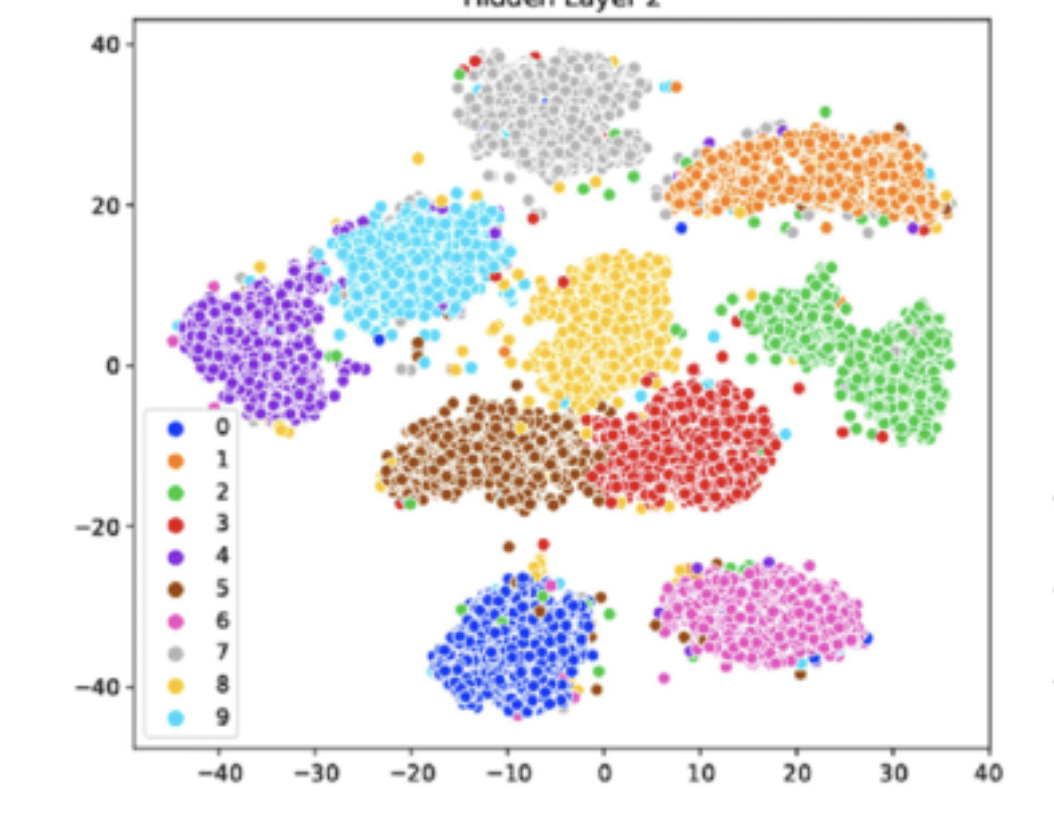

But, although we can't visualize high-dimensional spaces, the same principle of similarity (i.e., distance between points) applies to layers with high-dimensionality.


Networks are <i> compositions </i> of functions.

$$
 f(g(x))
$$

The more compositions, the "deeper", the neural network.

$$
f'(g'(f(g(x))))
$$


$$
f''(g''(f'(g'(f(g(x))))))
$$

$$
...
$$


An "architecture" is the fundamental set of components that define a particular neural network.


 Some Common Architectures
  e.g.,
  - feedforward (multi-layer perceptron)
  - recurrent
  - convolutional layer
  - external memory augmented systems
  - self-attention
  - ... your idea?




## Exploring an auto-encoder

An autoencoder seeks to reconstruct the data it receives, normally requiring that the data pass through a "bottleneck" (i.e., a low dimensional space). The weights throughout the network are updated so that the network's reconstructions (<b>x'</b>) look increasingly like the input data <b>x</b> ("self-supervised"). <b>Why should we care about simply <i>re-constructing</i> the input data?</b>.


It is analogous to some early learning problems in cognitive development.


In "Principles of Psychology" (1890) William James famously wrote:

 <i>"The baby, assailed by eyes, ears, nose, skin, and entrails at once, feels it all as one great blooming, buzzing confusion." (chapter 13, discrimination and comparison).</i>


With the auto-encoder and appropriate learning algorithms, we begin to consider how physical systems might tame James' "blooming, buzzing, confusion".

<!-- In principle, this "learning" could occur
  - <i>ontogenetically</i> -- over an individual's development. The empiricist position in philosophy favors knowledge acquisition over an individual's development.
  - <i>phylogenetically</i> -- over a species' evolution. The nativist tradition in philosophy emphasizes the importance of innate knowledge.
  - <i>or both</i>! inductive biases can speed learning, given experience. -->


 Learning is fundamentally about <b>reliably changing some physical state to reflect the structure of the world/data</b>.

For input data <b><i>x</b></i>, code <b><i>z</b></i>, and output <b><i>y</b></i>
 $$ X \rightarrow Z \rightarrow Y $$

<b>Categorization</b>, when y is a class,
<b>Action Selection</b>, when y is an action.
<b>Prediction</b>, when y is a future state
<b> Data compression </b>, when is x the currently available data.

<i>Can we learn about the world, given nothing more than the data itself?</i>

Given the statistical complexity of the world, we often want to learn simpler representations.

<b>Occam's Razor </b>: Simpler models of the data are preferable, all else being equal. This idea underlies data compression in computer science, as well as approaches to Statistical Inference (Rissanen, 1973).

The structure of the auto-encoder --- learning to reconstruct the data, given limited representational resources --- forces the learning of simpler representations, by virtue of force the data through a bottleneck that must have sufficient information to re-generate the data.

## An Auto-Encoder in Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

import torchvision

import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

Here, we deal with the MNIST dataset. Although not the best dataset for human learning, we use MNIST here because it is ubiquitous in machine learning for benchmarking learning algorithms. Some other datasets that may be of interest are [omniglot](https://github.com/brendenlake/omniglot) --- handwritten characters, many novel, that are better suited to comparing human and machine learning--- and CIFAR, visual images with more complex statistical and categorical structure (also common in ML).

 We will explore learning to reconstruct each image, with an auto-encoder, as well as classifying the digit associated with each image. (In Machine Learning, the former problem is considered "unsupervised" or "self-supervised", while the latter "supervised").


Next, we define a few <i> classes </i> that we can use. We will later create <i>instances</i> of these classes.

The first is the <i> encoder </i>>, which takes the input data <b>x</b> and maps it to some representation, which we will call <b>z</b>.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        #these values are specific to the MNIST dataset.
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

  #forward function defines structure of the network
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        #ReLu Activation Function: linear if positive, otherwise zero.
        x = F.relu(self.linear1(x))
        return self.linear2(x)

- <i> Forward Pass </i> -  the system runs the input data through each of its functions to make its best guess about the output. (inference/ information processing above)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        #ReLu Activation Function
        z = F.relu(self.linear1(z))
        #Sigmoid Activation Function
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

We can put the encoder and decoder pieces together to define an "Auto-encoder" class.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.Encoder = Encoder(latent_dims)
        self.Decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.Encoder(x)
        return self.Decoder(z)

This is the basic structure of information-processing in the network. For it to learn, we need to make <i> backward passes </i>

  - adjust the network parameters to minimize error in its guess. It does this by traversing backwards from the output, collecting the derivatives of the error with respect to the parameters of the functions (gradients), and optimizing those parameters using <i>gradient descent.</i>

  - In future classes, we will learn more about gradient descent and backpropagation, as well as other forms of optimization. For now, we gloss over the mechanics and simply ask pytorch to do the heavy lifting, iteratively updating the weights with each "batch" of training data, so as to minimize the loss function we have defined.


Here, the loss function is the mean squared error between the predicted targets (<b>x'</b>) and actual targets (<b>x</b>).

$$
 Loss_{MSE}  = \sum_{i=1}^{k}(x_i - \hat{x}_i)^2
$$


<!-- We will want to save our model.

def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)


def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch -->

In [ ]:
def train(autoencoder, data, epochs=1):
    results =[]
    opt = torch.optim.SGD(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()

            #model predictions
            x_hat = autoencoder(x)

            #mean squared error loss
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            results.append(loss)
    return autoencoder

In [ ]:
# Create datasets for training & testing, download if haven't already.

# train_set = torchvision.datasets.MNIST('./data', train=True,transform=torchvision.transforms.ToTensor(), download=True)
# test_set = torchvision.datasets.MNIST('./data', train=False,transform=torchvision.transforms.ToTensor(), download=True)

# # Create data loaders for MNIST datasets; shuffle for training, not for validation
# train_load = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
# test_load = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)

# # Report split sizes
# print('Training set has {} examples'.format(len(train_set)))
# print('Test set has {} examples'.format(len(test_set)))

Let's first look at some of the Digits we have loaded.

imgTensor, labels = next(iter(data))
plt.imshow(imgTensor[0,0,:,:])
plt.show()

Look ok? Let's train an auto-encoder with only 2 nodes in the latent space <b>z</b>.

In [ ]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)


100%|██████████| 9912422/9912422 [00:00<00:00, 224172537.08it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 50940157.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79243433.29it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2121439.73it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([128, 1, 28, 28])


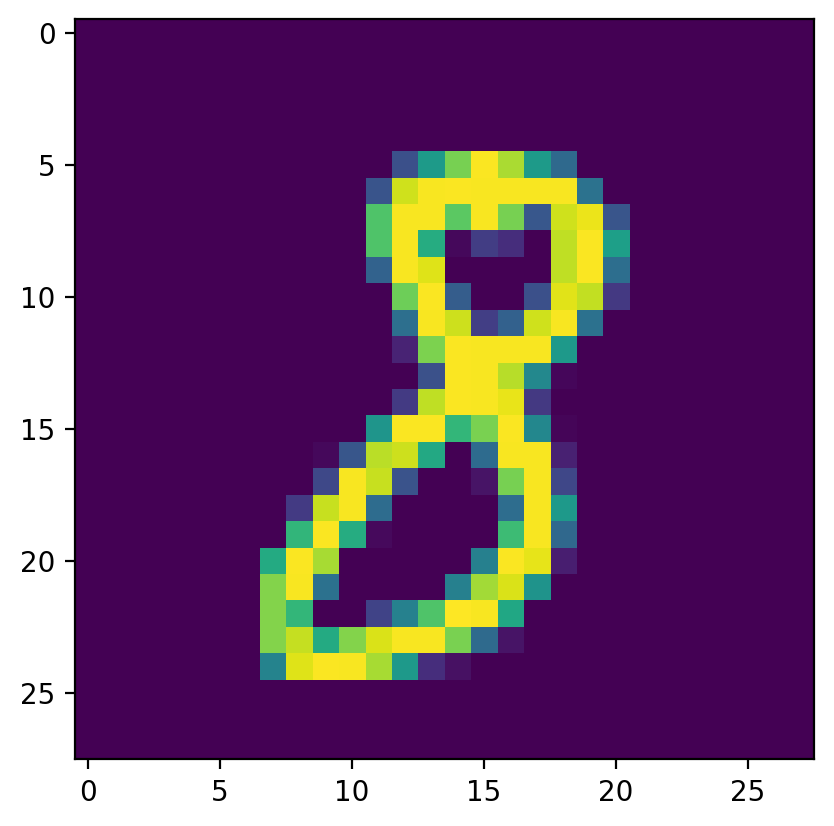

torch.Size([128, 1, 28, 28])


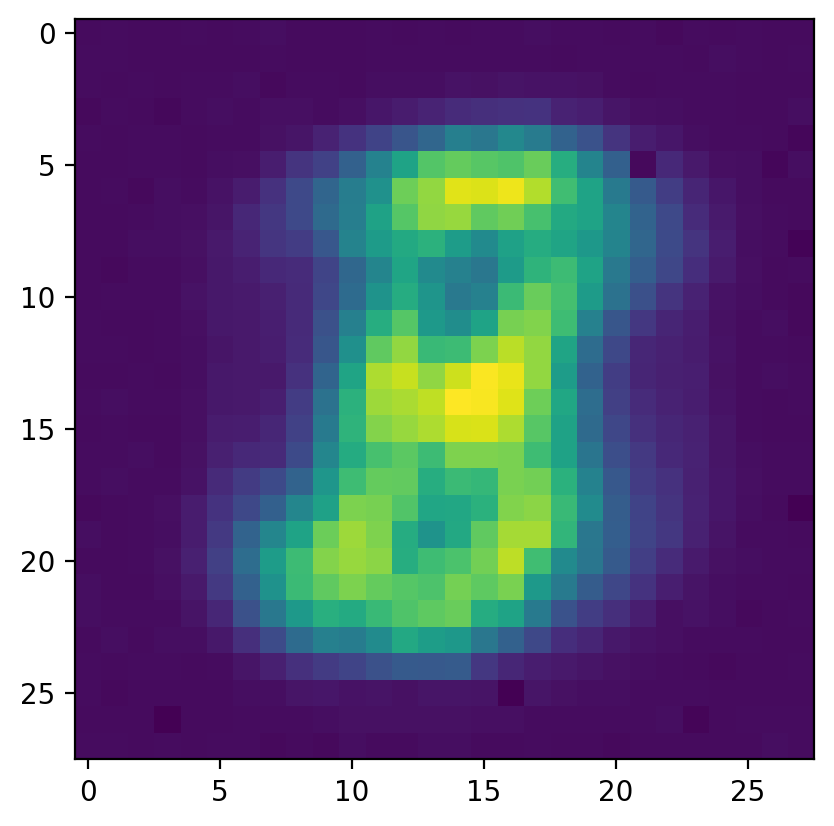

In [ ]:
with torch.no_grad():
  #visualize the true image.
  x,y= next(iter(data))
  print(x.shape)
  plt.imshow(x[0,0,:,:])
  plt.show()

  #visualize model reconstructions
  x_hat = autoencoder(x)
  print(x_hat.shape)
  plt.imshow(x_hat[0,0,:,:])
  plt.show()


Now, let's let it train for longer and come back and check again.

In [ ]:
autoencoder = train(autoencoder, train_set, epochs=10)

<!-- ```{code-cell} ipython3
def train(autoencoder, data, epochs=20):
    results =[]
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            
            #model predictions
            x_hat = autoencoder(x)

            #mean squared error loss
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            results.append(loss)
    return autoencoder
``` -->

## Machine Dreams

Thus far, the network has taken inputs (<b>x</b>), passed those inputs through successive layers to produce ouputs (<b>x'</b>). In between, the network has some interpretation (<b> z </b>) of x.

 But, of course, we can think about things that aren't immediately in front of us. We can spontaneously remember our high school friends, think about future dinner plans, imagine events that could never happen, for example: Margaret Thatcher dunking a basketball on Ronald Reagan.  This means that <b> z </b> can be caused by things other than the external input.

We will consider how minds and machines can generate <b>novel</b> thoughts later in the course. For now, we simply consider: how can neural networks generate new outputs without receiving inputs?

<!-- "Generative model" ---

Discriminative models, by contrast, "discriminate" between different kinds of data instances (using the conditional probability p(y | x)). Generative models generate new data instances. capture the joint probability (p(y,x)).  -->

First, let's directly intervene on the network's thoughts ourselves. Instead of passing the input through the encoder, let's simply "turn the dial" on the two latent nodes to see what the network re-creates as output. Given that the output is generated by z, (x'|z), let's try creating different z's.

First, we let's define a function that uniformly considers possible values of z.

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.Decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

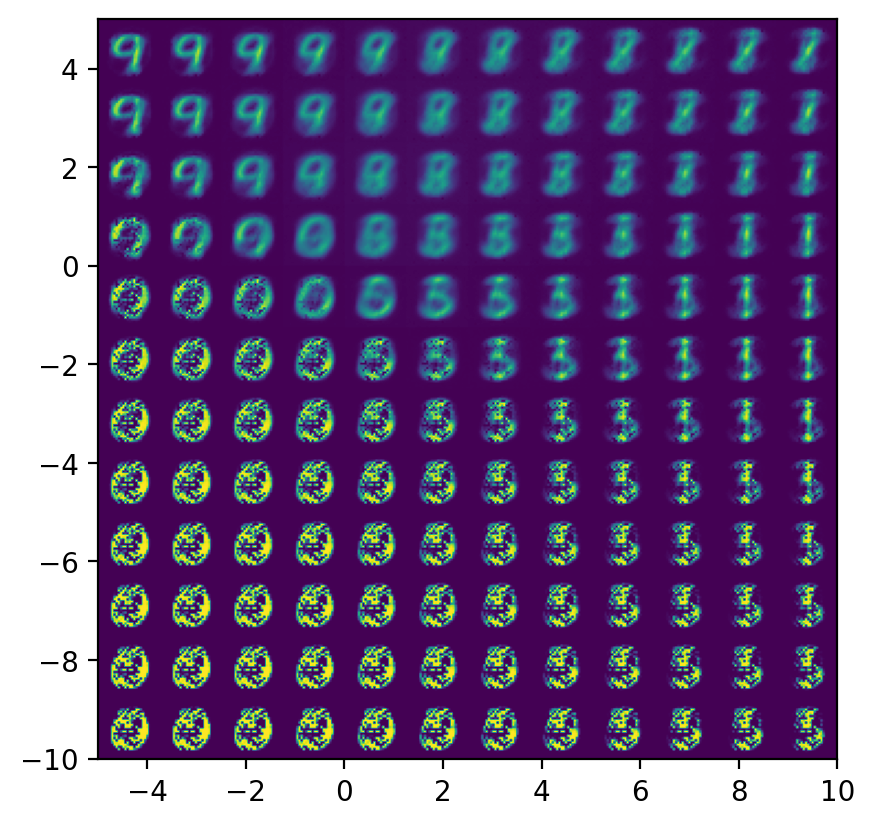

In [ ]:
plot_reconstructed(autoencoder)

We should see that similar values in z lead to similar outputs (x').


What would this network imagine if didn't control the nodes' activities ourselves? One approach: <i> Compute statistics of the latent nodes, then sample from the resulting probability distribution </i>.


Let's assume, for simplicity, that the two nodes have Gaussian probability distributions (i.e., "multivariate normal" distributions). This family of distributions is defined by their means (what's the average value of the variable?) and their variance/co-variance with other variables (how much does each variable change, and is that change correlated with changes in the other variable?).

The distributions may look something like this:


The basic auto-encoder is <i> <b> deterministic </b> </i>: given the same weights and values, it will always generate the same outputs.

Sampling is <i> <b> probabilistic </b> </i>. We assume a probability distribution, but random (stochastic) draws from that distribution, offering a different way to use neural networks to model human cognition.


<!--
```{code-cell} ipython3
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)
autoencoder = train(autoencoder, train_set)
``` -->

torch.Size([128, 1, 28, 28])


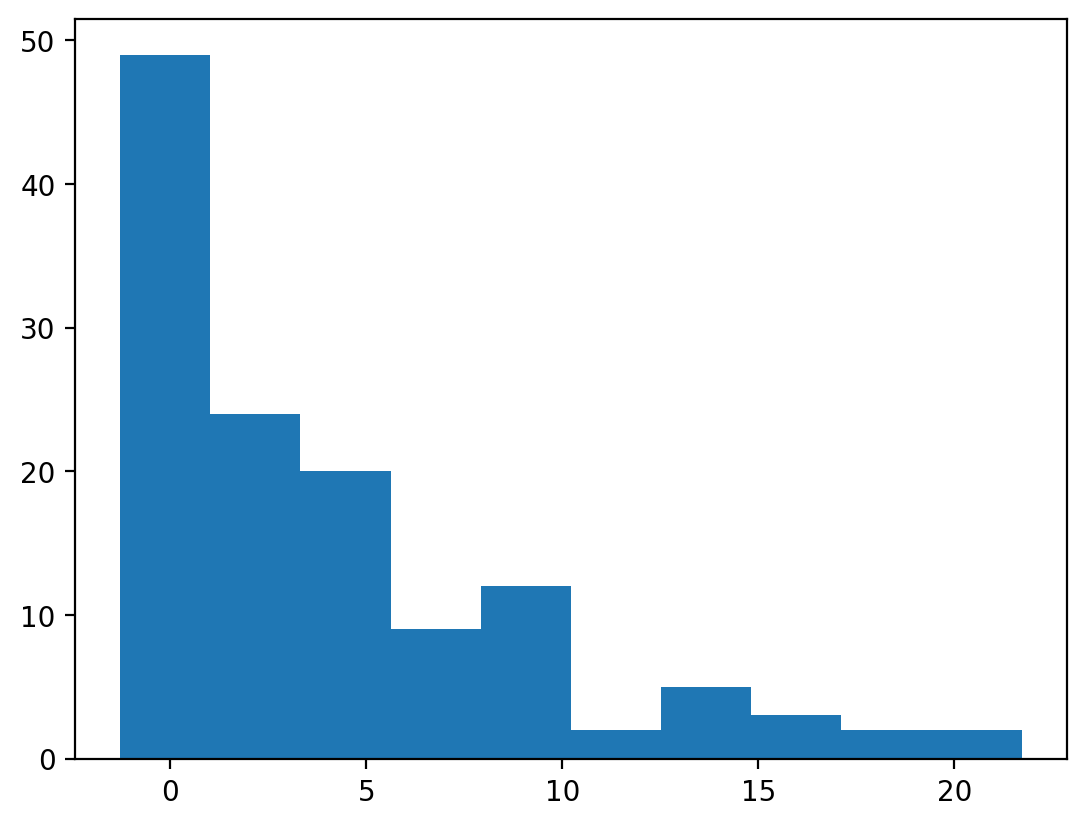

In [ ]:
import numpy.random as d

images, labels = next(iter(data))
print(images.shape)

#compute statistics of the latent nodes, over the dataset.
z = autoencoder.Encoder(images)

h = plt.hist(z[:,1].detach().numpy())

#define a Multivariate Gaussian Distribution using mean and variance of each node.
mu = torch.mean(z, 0)
v = torch.var(z, 0)

m_ = mu.detach().numpy()
v_ = v.detach().numpy()


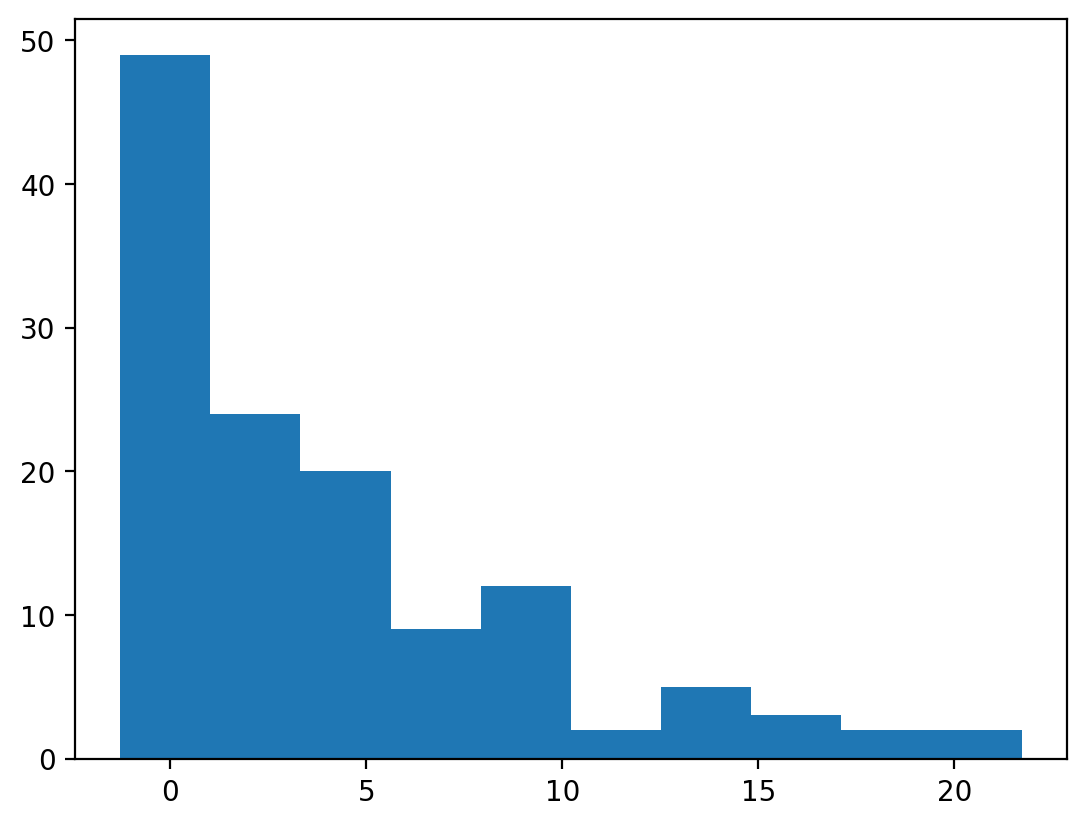

In [ ]:
h = plt.hist(z[:,1].detach().numpy())

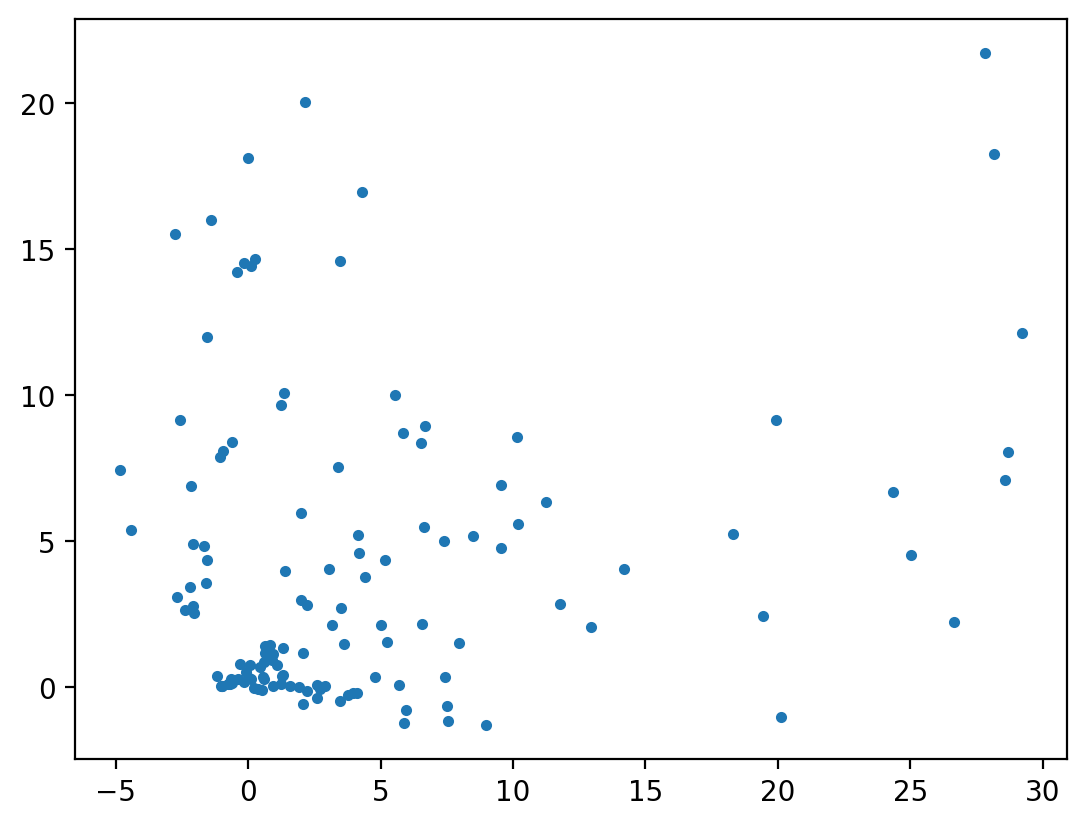

In [ ]:
plt.plot(z[:,0].detach().numpy(),z[:,1].detach().numpy(), '.')

Generate samples from that multivariate normal distribution.

In [ ]:
samples = []
n_samples = 1000

for i in range(n_samples):
    m = d.multivariate_normal(mean=m_, cov=np.eye(latent_dims)*v_)
    samples.append(m)

s=np.array(samples)


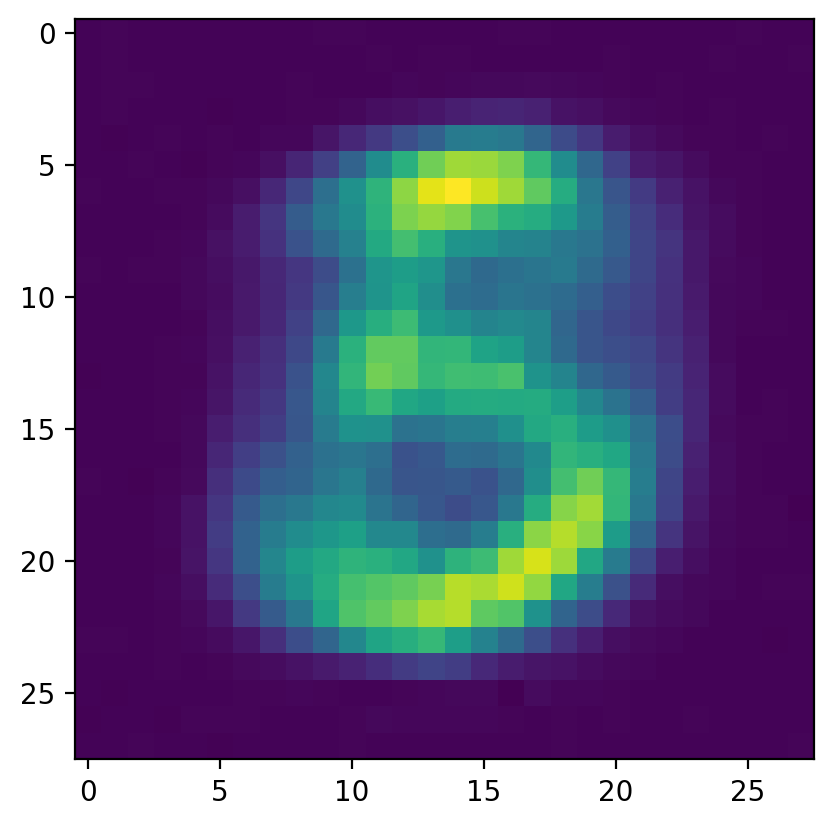

In [ ]:

#interpret a single random sample (i.e., what is it thinking about?)
z_ = torch.tensor(s[2,:], dtype=torch.float32)
x_=autoencoder.Decoder(z_)
x_ = x_.reshape(28, 28).detach().numpy()
plt.imshow(x_)
plt.show()

Let's define a function to visualize many thoughts as once.

In [ ]:

#plot a number of random samples.
#n_v_samples = number of samples to visualize.
def visualize_samples(autoencoder, n_v_samples=100):
    w = 28
    img = np.zeros((n_v_samples*w, n_v_samples*w))
    z_ = torch.tensor(s[0:n_v_samples,:], dtype=torch.float32)
    x_=autoencoder.Decoder(z_)
    x_ = x_.reshape(n_v_samples, 28, 28).detach().numpy()
    f, axarr = plt.subplots(round(n_v_samples**(1/2)),round(n_v_samples**(1/2)))
    ctr=0
    for i in range(round(n_v_samples**(1/2))):
        for p in range(round(n_v_samples**(1/2))):
          axarr[p,i].imshow(x_[ctr,:,:])
          ctr+=1
    plt.show()

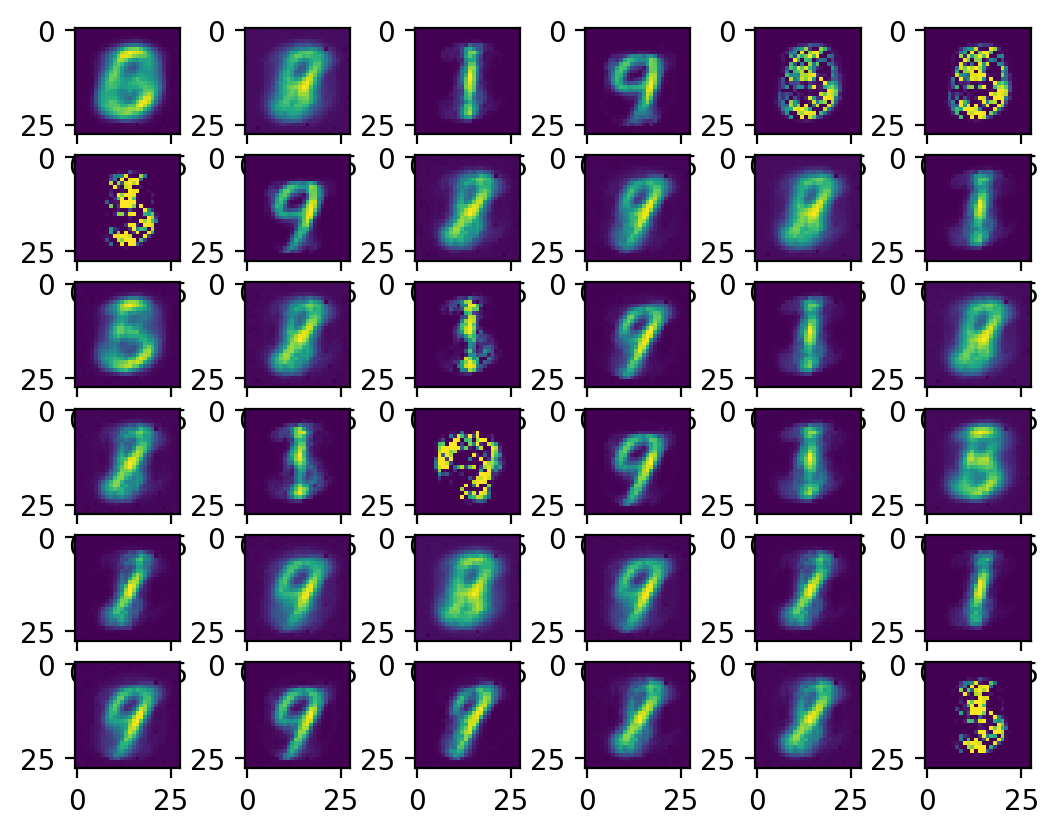

In [ ]:
visualize_samples(autoencoder, 36)

Looking at the visualization, does each number occur equally frequently? Or is it biased toward particular numbers?


[In future weeks, we will consider how an output can depend on previous timesteps, not simply stored knowledge in the weights.]


## Re-visiting One of Kahneman and Tversky's Heuristics in a Neural Net


#### Representativeness Heuristic

Recall from lecture that K&T thought the representativeness heuristic is the "substitution of a (descriptive) similarity judgment for a (normative) probability judgment." (Kahneman & Tversky, 1974; Heuristic and Biases) From a normative perspective, this is argued to be sub-optimal, leading to cognitive biases, such as <i> base-rate neglect </i>, <i>the conjunction fallacy </i>, and over-confidence in data from <i> small sample sizes </i>.

Neural networks naturally have a representational similarity space and make "decisions" based on these similarities. How can we model the types of decisions K&T study in a simple neural network?

When the data are drawn from categories, we might be interested in the learned statistical <i> prototype </i>of each category (Rosch, 1975). We can compute the similarity of any example to the centroid of the prototype using <i> inverse distance </i> in a representational space. This distance may differ for different layers of a neural network, depending on what those layers represent.

We can, for example, organized a plot of points in the latent space by number category.

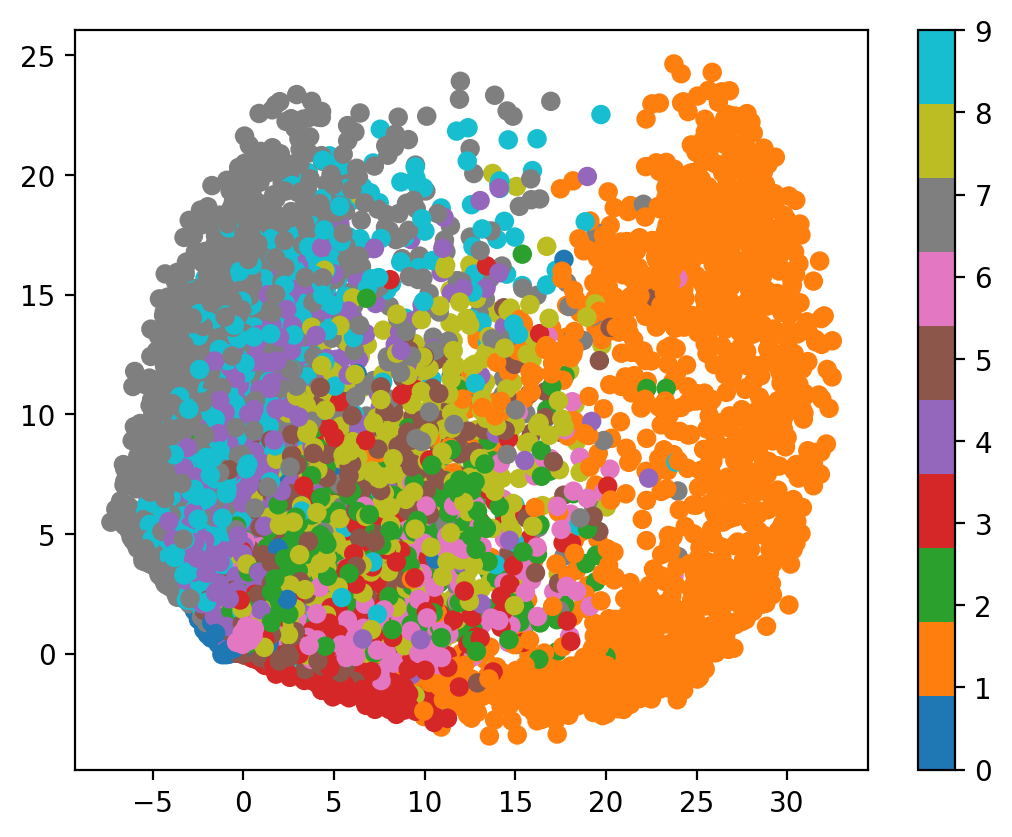

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.Encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break


plot_latent(autoencoder, data)

Or look only at the two's

But what does this mean for judgment and decision-making? Smooth, monotonic activation functions naturally treat nearby states as similar. For example, here is the sigmoid activation function.

$$
\sigma(z) = \frac{1} {1 + e^{-z}}
$$


![Sigmoid](./images/Sigmoid.png)


The input to each node is a weighted combination of the input vector (activities), passed through a smooth activiation function (filter).

![weighted](./images/weighted.jpg)


And, as before, we can visualize what smoothly changing a node's value does to "downstream" re-constructions.

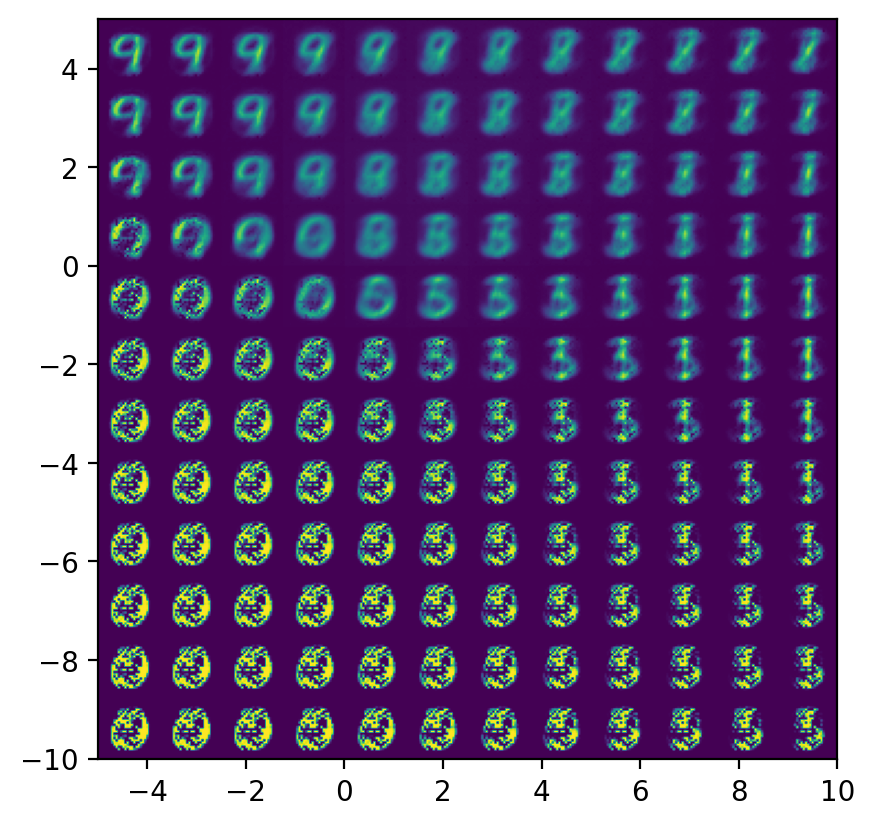

In [ ]:
plot_reconstructed(autoencoder)

This ability to perform similarity-based judgments is critical for the success of Large Language Models (LLMS): when the data are that expansive, and the network that high-dimensional, it's probable that there will be a useful similarity-space somewhere in the network.


Conceptual Questions to ponder:

Human can <i>selectively <b>attend</b> to particular latent dimensions </i>? (i.e., features that might be relevant) How might we go about doing this in a neural network?

Is there some way to accomodate Bayesian priors into the neural network's information-processing?


<!-- #### Availability Heuristic

K&T likewise higlighted ways in which the ease with which something comes to mind (incorrectly) influences explicit judgments regarding its probability.

Over the next two weeks we will study memory in physical systems in detail. But we can implement a quick model here.

Imagine we are sampling from the latent space, but the sampling is biased toward particular values, such that some states are retrieved with greater probability.


-frequency
-valence (positive/negative) -->




## A Supervised Category-Learning Problem

Now, let's consider the classic supervised learning problem with MNIST, in which the network is given the correct "label" for each image, and tasked with learning the numerical categories ("0", "1", "2", etc.). This contrasts with the auto-encoder, which is simply learning to re-construct the input data it is given.


Let's again import the relevant python functionality.

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt

load MNIST Train and Test data

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=4, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=4, shuffle=True)

In [ ]:
##Define MLP class
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(28*28, 50)
        self.linear2 = nn.Linear(50, 25)
        self.final = nn.Linear(25, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x
net = Net()

define loss and optimizer. for classification tasks (i.e., w/ categorical ouptut variables), Cross Entropy loss is common.

Cross-Entropy

$$
 -\sum_{c=1}^My_{o,c}\log(p_{o,c})
$$

In [ ]:
Xent = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 5
results=[]

In [ ]:
#model training and evaluation loop.
for epoch in range(epochs):
    net.train()
    print(epoch)
    #evaluate model performance
    correct=0
    total=0

    for data in train_loader:
        x, y = data
        optimizer.zero_grad()
        output = net(x.view(-1, 28*28))
        loss = Xent(output, y)
        loss.backward()
        optimizer.step()
        output = net(x.view(-1, 784))

  ####here we collect the results for each training batch, so we can plot the learning over time.

        for idx, i in enumerate(output):
          if torch.argmax(i) == y[idx]:
            correct +=1
          total +=1
          print(f'accuracy: {round(correct/total, 3)}')

          #append this to the results structure we initialized.
          results.append(round(correct/total, 3))

print('Done Training!')

Streaming output truncated to the last 5000 lines.
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accuracy: 0.94
accu

Let's plot the results!

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_results)
plt.show()